<a href="https://colab.research.google.com/github/shliakhtas/ASCM/blob/main/real_estate_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopandas

     |████████████████████████████████| 972kB 8.2MB/s 
     |████████████████████████████████| 10.9MB 20.2MB/s 
     |████████████████████████████████| 14.8MB 311kB/s 


In [ ]:
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import requests
import pandas as pd
import re
import numpy as np
from datetime import datetime, timedelta
from geopandas import GeoDataFrame
import folium
import shapely.affinity
from shapely.geometry import Point
import geopy
import geopy.distance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shp_path = "./drive/My Drive/roads/gis_osm_roads_free_1.shp"
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4319972,5122,residential,Володимирська вулиця,None,B,50,0,F,F,"LINESTRING (30.51809 50.45791, 30.51806 50.457..."
1,4319974,5113,primary,Набережно-Хрещатицька вулиця,None,F,40,0,F,F,"LINESTRING (30.52383 50.46943, 30.52389 50.469..."
2,4327781,5115,tertiary,Ревуцького вулиця,None,F,0,0,F,F,"LINESTRING (30.64523 50.41266, 30.64531 50.412..."
3,4327811,5114,secondary,Зої Гайдай вулиця,None,F,50,0,F,F,"LINESTRING (30.49431 50.51264, 30.49411 50.512..."
4,4327812,5114,secondary,Йорданська вулиця,None,F,50,0,F,F,"LINESTRING (30.50770 50.48887, 30.50754 50.488..."


In [ ]:
now = datetime.now()-timedelta(hours=3)
yesterday = now - timedelta(days=1)
before_yesterday = now - timedelta(days=2)
today = now.strftime("%d-%m-%Y")
yesterday = yesterday.strftime("%d-%m-%Y")
before_yesterday = before_yesterday.strftime("%d-%m-%Y")
print(today)
print(yesterday)

24-10-2020
23-10-2020


In [ ]:
# Put in list the lists of sities to search from web-site and numbers of the pages, you whanted to scrape
cities = [['lvov',5]]

In [ ]:
def scrape_dom_ria_ua(city):
  aa = []
  for s in range(0,city[1]):
    url1 = 'https://dom.ria.com/uk/arenda-kvartir/'+city[0]+'/?page='+str(s)
    headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
  
    page = requests.get(url1,headers= headers)
    soupysoupy = BeautifulSoup(page.text,'html.parser')

    address = []
    addr = soupysoupy.find_all("div",{'class':'wrap_desc'})
    for a in addr:
        data_addr = a.text.strip()
        address.append(data_addr)
        adr = re.findall(r'\S+',data_addr)
        # print(adr)
        for tt,t in enumerate(adr):
          district = adr[1]
          if t=='м.':
            try:   
              sity = city[0]
              price = int(adr[tt+5]+adr[tt+6])
              price_dollars = int(adr[tt+8])
              rooms = adr[tt+10]
              squere = adr[tt+12]
              description = ' '.join(adr[tt+18:len(adr)-2])
              date = adr[len(adr)-1]
              if len(' '.join(adr[3:tt]))<50 :
                street = ' '.join(adr[2:tt])
            except:
              print(s, '   :    ', tt )
            aa.append(np.array([district,street,sity,price,price_dollars, rooms, squere, description,date]))
            # return aa
    df = pd.DataFrame(aa,columns=['district','street','sity','price','price_dollars', 'rooms', 'squere','description', 'date'])
    return df

# def scrape_olx(city):
#   aa = []
#   for s in range(0,city[1]):
#     url1 = 'https://www.olx.ua/uk/nedvizhimost/kvartiry-komnaty/arenda-kvartir-komnat/kvartira/'+city[0]+'/?page='+str(s)
#     headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
  
#     page = requests.get(url1,headers= headers)
#     soupysoupy = BeautifulSoup(page.text,'html.parser')

#     address = []
#     addr = soupysoupy.find_all("div",{'class':'offer-wrapper'})
#     for a in addr:
#         data_addr = a.text.strip()
#         address.append(data_addr)
#         adr = re.findall(r'\S+',data_addr)
#         print(adr, 'adr')
 

In [ ]:
# start scrapping
for city in cities:
  df = scrape_dom_ria_ua(city)
df = pd.DataFrame(aa,columns=['district','street','sity','price','price_dollars', 'rooms', 'squere','description', 'date'])
df.head(6)

In [ ]:
# use it to save dataframe to Google Drive
# df.to_csv('realestatelviv5000.csv')
# !cp realestatelviv5000.csv "drive/My Drive/"

# use this code if you already create dataframe
df = pd.read_csv("drive/My Drive/realestatelviv5000.csv")
df.pop('Unnamed: 0')
df

In [ ]:
# delete not-realistic prices
# df = df[len(df['price'])>4]

# delete prefixes
df['street']=df['street'].agg(lambda x: x.replace('вул.', '').replace('ул.', '').replace('вулиця', '').replace('улица.', '')
.replace('просп.', '').replace('пр.', '').replace('проспект', '').replace('прос.', '').replace('в.', '').replace('п.', ''))
df['street']=df['street'].agg(lambda x: x.str.strip())

# delete whitespases
df['district']=df['district'].agg(lambda x: x.str.strip())

# delete rows with empty street
df = df[df['street']!= ""] 

# convert date from ['Tommorow', 'hover ago'] to correct format
d = []
for a in df['date']:
  if str(a)=='Вчора':
    d.append(yesterday)
  elif str(a)=='тому':
    d.append(today)
  elif str(a)=='Позавчора':
    d.append(before_yesterday)
  else:
    d.append(a)
df['date'] = d

# convert columns to numeric values
df['price'] = pd.to_numeric(df["price"], errors='coerce')
df['squere'] = pd.to_numeric(df["squere"], errors='coerce')
df['rooms'] = pd.to_numeric(df["rooms"], errors='coerce')

# # convert date to datetype
# df['date'] = pd.to_datetime(df['date'])

# calculate price per squere and room
df['price_per_squere']= df['price'] / df['squere']
df['price_per_room']= df['price'] / df['rooms']

df.head(5)

0
0


,district,street,sity,price,price_dollars,rooms,squere,description,date,price_per_squere,price_per_room
0,Личаківський,Круп'ярська,lvov,11364,400,1.0,50.0,здається в оренду на довготривалий період одно...,24.09.2020,227.280000,11364.0
1,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0
2,Шевченківський,Шпитальна,lvov,8000,282,2.0,52.0,Здається в оренду 2 кімнатна квартира на вулиц...,21.09.2020,153.846154,4000.0
3,Сихів,Червоної Калини,lvov,11000,387,1.0,38.0,Перевірений ріелтор xxxxx Реєстраційний номер ...,12.08.2020,289.473684,11000.0
4,Франківський,Княгині Ольги,lvov,11364,400,1.0,48.0,Здам 1 кімнатну-студіо квартиру 48м2 на тривал...,26-09-2020,236.750000,11364.0


In [ ]:
# set coordinates
center = [49.8471,24.0314]
top = 49.9398
bottom = 49.7572
left = 23.8752
right = 24.2065

# create an ellipse
radius_lat = geopy.distance.distance(kilometers = 21).destination(point=center, bearing=0)[0] - center[0]
radius_lon = geopy.distance.distance(kilometers = 17).destination(point=center, bearing=90)[1] - center[1]

circle = Point(center[::-1]).buffer(1)
ellipse = shapely.affinity.scale(circle, radius_lon, radius_lat)

# show ellipse
ellipse_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')
folium.PolyLine(list([c[::-1] for c in ellipse.exterior.coords])).add_to(ellipse_map)
ellipse_map

In [ ]:
# take only roads, which ellipse includes
lviv = roads.loc[roads['geometry'].apply(lambda g: ellipse.contains(g))].copy()
lviv = lviv[lviv.fclass.isin(['trunk', 'primary']) | lviv['name'].notnull()]

# create column with streets names
lviv['name'] = lviv['name'].fillna(value='')
lviv['street'] = lviv['name'].apply(lambda name: name.split(' ')[0] if name is not None else None)

# create column with streets types and calculate their counts
lviv['postfix'] = lviv['name'].apply(lambda name: name.split(' ')[-1] if name is not None else None)

def get_designation(name):
    name = name.lower()
    if 'провулок' in name: return 'провулок'
    elif 'ряд' in name: return 'ряд'
    elif 'вулиця' in name: return 'вулиця'
    elif 'проїзд' in name: return 'проїзд'
    elif 'проспект' in name: return 'проспект'
    elif 'майдан' in name: return 'майдан'
    elif 'площа' in name: return 'площа'
    elif 'набережна' in name: return 'набережна'
    elif 'бульвар' in name: return 'бульвар'
    elif 'пасаж' in name: return 'пасаж'
    # elif any(ext in name for ext in ['мкад', 'третье транспортное', 'хорда', 'тоннель', 'путепровод', 'эстакада', 'рокада']):
    #     return 'магістраль'
    else: return 'інші'

lviv['designation'] = [get_designation(name) for name in lviv['name']]

print(lviv.designation.value_counts())
lviv.head(5)

вулиця      5406
інші         624
проспект     177
площа         96
провулок      43
ряд           14
проїзд        12
майдан         8
пасаж          5
Name: designation, dtype: int64


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,street,postfix,designation
234,4773701,5114,secondary,Окружна вулиця,None,F,50,0,F,F,"LINESTRING (23.98271 49.82706, 23.98297 49.826...",Окружна,вулиця,вулиця
235,4773702,5114,secondary,Володимира Антоновича вулиця,None,F,50,0,F,F,"LINESTRING (23.98891 49.82515, 23.98904 49.825...",Володимира,вулиця,вулиця
236,4773827,5113,primary,Кульпарківська вулиця,None,B,50,0,F,F,"LINESTRING (23.99079 49.83466, 23.99082 49.834...",Кульпарківська,вулиця,вулиця
237,4773828,5115,tertiary,Митрополита Андрея вулиця,None,F,50,0,F,F,"LINESTRING (24.01234 49.83719, 24.01216 49.837...",Митрополита,вулиця,вулиця
238,4774025,5114,secondary,Свободи проспект,None,F,50,0,F,F,"LINESTRING (24.02964 49.83976, 24.02937 49.83987)",Свободи,проспект,проспект


In [ ]:
# merge twho dataframes and convert it to geopandas
s = df.merge(lviv, on='street')
gdf = GeoDataFrame(s, geometry = s['geometry'])
gdf.set_crs(epsg=4326, inplace=True, allow_override=True)
gdf.head(5)

,district,street,sity,price,price_dollars,rooms,squere,description,date,price_per_squere,price_per_room,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,postfix,designation
0,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,42365343,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02819 49.85365, 24.02816 49.853...",вулиця,вулиця
1,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,58261572,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02854 49.84722, 24.02837 49.847...",вулиця,вулиця
2,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,73172524,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02669 49.86150, 24.02667 49.86171)",вулиця,вулиця
3,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,161250671,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.01907 49.87098, 24.01873 49.871...",вулиця,вулиця
4,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,161250673,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02291 49.86926, 24.02197 49.86968)",вулиця,вулиця


In [ ]:
gdf['lat'] = gdf['geometry'].apply(lambda x: x.xy[0])
gdf['lon'] = gdf['geometry'].apply(lambda x: x.xy[1])


In [ ]:
# df.drop_duplicates(['description'])

# group by street and calculate for each groups mean price per squere and per room and their count
df2= gdf.groupby(['district','street'], as_index=False).agg(
      mean_per_room=('price_per_room','mean'),
      mean_per_squere=('price_per_squere','mean'), 
      count=('price_per_room','count')
     )

# check if there not only one offer on the street
df2=df2[df2['count']>2].reset_index()

print(df2.head(5))

# put that values in the main dataframe
s = gdf.merge(df2, on=['street', 'district'])
newgdf = GeoDataFrame(s, geometry = s['geometry'])

newgdf.head(5)

   index     district      street  mean_per_room  mean_per_squere  count
0      0   Боднарівка  Боднарська    8500.000000       173.469388      4
1      1    Брюховичі   Львівська    4261.333333       161.822785     29
2      3   Вашингтона     Джорджа    9000.000000       180.000000     16
3      4  Виговського       Івана    8500.000000       184.782609    291
4      5      Винники     Кінцева    4000.000000       190.476190      4


,district,street,sity,price,price_dollars,rooms,squere,description,date,price_per_squere,price_per_room,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,postfix,designation,lat,lon,index,mean_per_room,mean_per_squere,count
0,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,42365343,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02819 49.85365, 24.02816 49.853...",вулиця,вулиця,"[24.028188, 24.0281624, 24.0281738, 24.0282013]","[49.8536455, 49.8538873, 49.8543785, 49.8547269]",14,4502.006563,176.500459,112148
1,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,58261572,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02854 49.84722, 24.02837 49.847...",вулиця,вулиця,"[24.0285446, 24.0283742, 24.0280152, 24.027804...","[49.8472194, 49.8474014, 49.8477849, 49.848043...",14,4502.006563,176.500459,112148
2,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,73172524,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02669 49.86150, 24.02667 49.86171)",вулиця,вулиця,"[24.026694, 24.0266709]","[49.8614951, 49.8617122]",14,4502.006563,176.500459,112148
3,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,161250671,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.01907 49.87098, 24.01873 49.871...",вулиця,вулиця,"[24.019068, 24.0187336, 24.0186051, 24.0183739...","[49.8709809, 49.8711192, 49.8711724, 49.871265...",14,4502.006563,176.500459,112148
4,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,161250673,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02291 49.86926, 24.02197 49.86968)",вулиця,вулиця,"[24.0229128, 24.0219691]","[49.8692619, 49.8696841]",14,4502.006563,176.500459,112148


In [ ]:
# create gradations
def make_gradation(category, df):
  categories = df.describe()[category]
  delta = (categories.iloc[7] - categories.iloc[3])/5
  first = categories.iloc[3]
  second = first+delta
  third = second+delta
  fourth = third+delta
  fiveth = fourth+delta
  return [first, second, third, fourth, fiveth]

categories_per_room = make_gradation('mean_per_room', newgdf)
categories_per_squere = make_gradation('mean_per_squere', newgdf)
categories_count = make_gradation('count', newgdf)

def make_grad(g, l):
  if g<l[1]:
      grad = 'first'
  elif g>=l[1] and g<l[2]:
      grad = 'second'
  elif g>=l[2] and g<l[3]:
      grad = 'third'
  elif g>=l[3] and g<l[4]:
      grad = 'fourth'
  elif g>=l[4]:
      grad = 'fiveth'
  return grad

newgdf['per_room_grad'] = newgdf['mean_per_room'].agg(lambda x : make_grad(x, categories_per_room))
newgdf['per_squere_grad'] = newgdf['mean_per_squere'].agg(lambda x : make_grad(x, categories_per_squere))
newgdf['count_grad'] = newgdf['count'].agg(lambda x : make_grad(x, categories_count))

# create colors columns
colors = {
    'first': '#59c8e5',
    'second': '#59c8e5',
    'third': '#fed032',
    'fourth': '#fec301',
    'fiveth': '#fe4d64'
}
def makecolors(grad):
  return colors[grad]
newgdf['per_room_grad_color'] = newgdf['per_room_grad'].agg(lambda x : makecolors(x))
newgdf['per_squere_grad_color'] = newgdf['per_squere_grad'].agg(lambda x : makecolors(x))
newgdf['count_grad_color'] = newgdf['count_grad'].agg(lambda x : makecolors(x))

# create gradation for date
datelimits = []
for y in list([['2019', '2020', '9'], ['2018', '2019', '8'], ['2017', '2018', '8'], ['2016', '2017', '8']]):
  datelimits = datelimits + [['01-12-2'+y[0], '01-2'+y[2]+'-'+y[1]],['01-03-'+y[1], '31-05-'+y[1]],['01-06-'+y[1], '31-08-'+y[1]],['01-09-'+y[1], '30-11-'+y[1]]]
print(datelimits)
def make_date_grad(date):
  for a in datelimits:
    if str(date)>a[0] and str(date)<a[1]:
      dateclass = a[0] + ':' + a[1]
      return dateclass
newgdf['date_grad'] = newgdf['date'].agg(lambda x : make_date_grad(x))
newgdf


[['01-12-22019', '01-29-2020'], ['01-03-2020', '31-05-2020'], ['01-06-2020', '31-08-2020'], ['01-09-2020', '30-11-2020'], ['01-12-22018', '01-28-2019'], ['01-03-2019', '31-05-2019'], ['01-06-2019', '31-08-2019'], ['01-09-2019', '30-11-2019'], ['01-12-22017', '01-28-2018'], ['01-03-2018', '31-05-2018'], ['01-06-2018', '31-08-2018'], ['01-09-2018', '30-11-2018'], ['01-12-22016', '01-28-2017'], ['01-03-2017', '31-05-2017'], ['01-06-2017', '31-08-2017'], ['01-09-2017', '30-11-2017']]


,district,street,sity,price,price_dollars,rooms,squere,description,date,price_per_squere,price_per_room,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,postfix,designation,lat,lon,index,mean_per_room,mean_per_squere,count,per_room_grad,per_squere_grad,count_grad,date_grad,per_room_grad_color,per_squere_grad_color,count_grad_color
0,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,42365343,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02819 49.85365, 24.02816 49.853...",вулиця,вулиця,"[24.028188, 24.0281624, 24.0281738, 24.0282013]","[49.8536455, 49.8538873, 49.8543785, 49.8547269]",14,4502.006563,176.500459,112148,second,third,second,01-03-2020:31-05-2020,#59c8e5,#fed032,#59c8e5
1,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,58261572,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02854 49.84722, 24.02837 49.847...",вулиця,вулиця,"[24.0285446, 24.0283742, 24.0280152, 24.027804...","[49.8472194, 49.8474014, 49.8477849, 49.848043...",14,4502.006563,176.500459,112148,second,third,second,01-03-2020:31-05-2020,#59c8e5,#fed032,#59c8e5
2,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,73172524,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02669 49.86150, 24.02667 49.86171)",вулиця,вулиця,"[24.026694, 24.0266709]","[49.8614951, 49.8617122]",14,4502.006563,176.500459,112148,second,third,second,01-03-2020:31-05-2020,#59c8e5,#fed032,#59c8e5
3,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,161250671,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.01907 49.87098, 24.01873 49.871...",вулиця,вулиця,"[24.019068, 24.0187336, 24.0186051, 24.0183739...","[49.8709809, 49.8711192, 49.8711724, 49.871265...",14,4502.006563,176.500459,112148,second,third,second,01-03-2020:31-05-2020,#59c8e5,#fed032,#59c8e5
4,Галицький,Замарстинівська,lvov,9000,317,2.0,51.0,Від власника 2-х кімнатна квартира в 10 хвилин...,14.07.2020,176.470588,4500.0,161250673,5114,secondary,Замарстинівська вулиця,None,B,50,0,F,F,"LINESTRING (24.02291 49.86926, 24.02197 49.86968)",вулиця,вулиця,"[24.0229128, 24.0219691]","[49.8692619, 49.8696841]",14,4502.006563,176.500459,112148,second,third,second,01-03-2020:31-05-2020,#59c8e5,#fed032,#59c8e5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543409,Снопків,Снопківська,lvov,13000,458,2.0,80.0,Перевірений ріелтор xxxxx Реєстраційний номер ...,27.08.2020,162.500000,6500.0,481369228,5114,secondary,Снопківська вулиця,None,F,50,0,F,F,"LINESTRING (24.03740 49.82496, 24.03724 49.82526)",вулиця,вулиця,"[24.0373992, 24.0372377]","[49.8249617, 49.825259]",96,6500.000000,162.500000,4,third,third,first,01-03-2020:31-05-2020,#fed032,#fed032,#59c8e5
543410,Личаківський,Жасминова,lvov,9900,348,2.0,70.0,Здається в оренду власниками сучасна 2-х кімна...,27.08.2020,141.428571,4950.0,182821551,5122,residential,Жасминова вулиця,None,B,20,0,F,F,"LINESTRING (24.05769 49.82174, 24.05775 49.821...",вулиця,вулиця,"[24.0576884, 24.057752, 24.0578044, 24.0581704...","[49.8217398, 49.8217919, 49.8218945, 49.822291...",54,4950.000000,141.428571,4,second,second,first,01-03-2020:31-05-2020,#59c8e5,#59c8e5,#59c8e5
543411,Личаківський,Жасминова,lvov,9900,348,2.0,70.0,Здається в оренду власниками сучасна 2-х кімна...,27.08.2020,141.428571,4950.0,197530243,5122,residential,Жасминова вулиця,None,B,0,0,F,F,"LINESTRING (24.05769 49.82174, 24.05760 49.821...",вулиця,вулиця,"[24.0576884, 24.0575979, 24.057268, 24.0567126...","[49.8217398, 49.8216852, 49.8215957, 49.821416...",54,4950.000000,141.428571,4,second,second,first,01-03-2020:31-05-

In [ ]:
newgdf.to_csv('newgdf.csv')
!cp newgdf.csv "drive/My Drive/"

In [ ]:
pip install contextily

     |████████████████████████████████| 18.1MB 228kB/s 


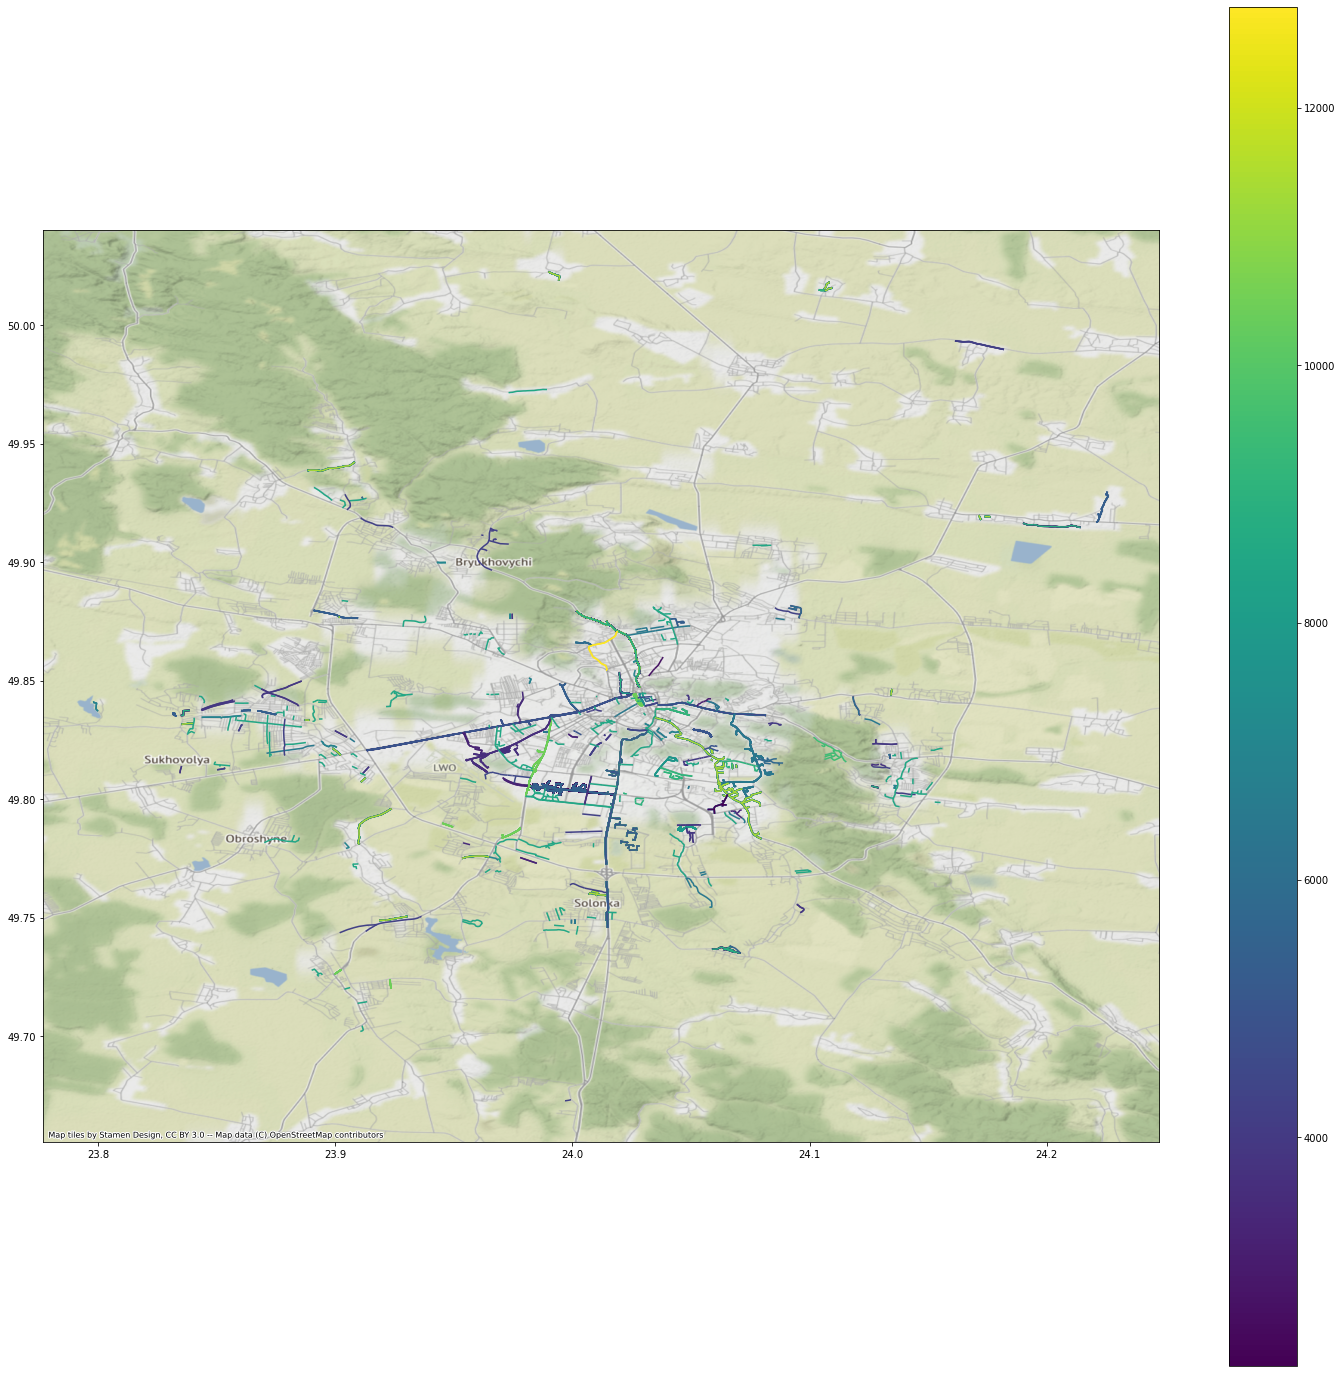

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(25,25), subplot_kw={'aspect':'equal'})
aa = newgdf.plot(column='mean_per_room',   k=5, legend=True, ax=ax)
ctx.add_basemap(aa, crs=4326, zoom=12)